# 1K2F G-ADSA Analysis

In this document, we perform the gravimetry-axisymmetric drop shape analysis (G-ADSA) of a sample of proprietary Dow polyol, which is difunctional with molecular weight ~1000 g/mol in an atmosphere of carbon dioxide. The experiment was performed in the lab of Prof. Ernesto Di Maio in the Department of Chemical Engineering, Materials, and Industrial Production (DICMaPI) at the University of Naples Federico II from July 1-5, 2019.

The analysis computes the **solubility, interfacial tension, diffusivity, and specific volume** of the sample at pressures from 0 to 55 bar at 60 C.

We begin by importing the required Python libraries and setting parameters for this particular analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import curve_fit
import dataproc
import errprop
import plot

from importlib import reload
reload(dataproc)
reload(errprop)


# SET PARAMETERS
# folder for ADSA data
adsa_folder = '../../EXPERIMENTS/Italy/data/adsa/'
# list of data files with pendant drop volume (only) for ADSA generated from videos of a pendant drop
adsa_volume_file_list = ['20190701_0705_1k2f_60c_adsa_volume.csv']
# list of data files with interfacial tension data--leave blank if not complete
adsa_if_tension_file_list = ['20190701_0705_1k2f_60c_adsa_if_tension.csv']
# file path for gravimetry data from the Rubotherm machine
grav_file_path = '../../EXPERIMENTS/Italy/data/gravimetry/1k2f_60c-TRD-070119-1900.csv'
# file path to save results
save_folder = '../g-adsa_results/'
save_data_name = '1k2f_60c.csv'
save_plots = True
# list of starting times of ADSA data relative to start of gravimetry data
# gravimetry 7/1 19:01:21; adsa video 7/1 19:02
adsa_t0_list = [39]
# number of measurements to average for surface tension and volume readings
n_adsa = 10

# polyol code name
polyol = '1k2f'
# weight of sample in atmospheric pressure [g]
w_samp_atm = 0.7293
# volume of drop in atmospheric pressure, from 20190701_1k2f_rod_alignment.mdb and measurement w/ ppt and python [uL]
v_drop_atm = 3.58
# density of polyol sample from Dow technical data sheet at atmospheric pressure and 25 C (TDS)
# and extrapolated using P-1000 Dow data [g/mL]
rho_samp_atm = 0.993
# volume of hook and crucible as measured in helium [mL]
v_ref_he = 2.2674 # extrapolated from measurement by Maria Rosaria Di Caprio @ 25 C [mL]
diam_cruc = 1.82 # diameter of crucible [cm]
br_cruc = 7.2788 - 0.0003 # balance reading of crucible without polymer at atmospheric pressure [g]

# ordered list of pressure set points (within p_thresh_frac of true values) [kPa]
p_set_arr = np.array([0, 50, 100, 200, 550, 1050, 1550, 2030, 2530, 3020, 3510, 4000, 4500,
                       4970, 5340, 4600, 3850, 3120, 2380, 1630, 890, 690, 500, 290]) # the lower pressures lack ADSA data, data at 5400 has inaccurate ADSA
p_thresh_frac = 0.04 # threshold for acceptable difference between actual pressure and set pressure [fraction]
# number of measurements of pressure within equilibrium (300 s, every 30 s)
n_p_eq = 10

# CONSTANTS
# Set-point temperature [C]
T = 60
# atmospheric pressure [kPa]
P_ATM = 101.3
# mass of crucible and hooks measured June 26 with Rubotherm in atmosphere [g]
TARE = 7.2788 - 0.0003 + dataproc.rho_co2(P_ATM, T)*v_ref_he 

# NOTE: PARAMETERS FOR ERROR PROPAGATION ARE DECLARED IN THE "ERROR PROPAGATION" SECTION

## Load Raw Data

Next we load the raw data from gravimetry and ADSA that we wish to process.

In [2]:
# load (and validate) raw data
df, br_arr, bp_arr, p_arr, t_grav, v_drop, t_adsa = dataproc.load_raw_data(adsa_folder, adsa_volume_file_list, \
                                                                                      adsa_t0_list, grav_file_path, p_set_arr)
df.head()

,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,dissolved gas balance reading [g],buoyancy correction [g],actual weight of dissolved gas [g],solubility [w/w],solubility error [w/w],specific volume [mL/g],specific volume error [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (exp) [cm^2/s],diffusion time constant [s]
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Synchronize Gravimetry and ADSA Measurements

In the next section, we synchronize gravimetry and ADSA measurements and identify their corresponding pressures. We then average the final values of the measurements of mass, tare, and interfacial tension (and take the standard deviation as an estimate of the error) and save them for further analysis.

Pressure = 0 kPa.
Rejected 1 outliers.


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Drop volume = 3.599900 uL.
Pressure = 50 kPa.
Rejected 1 outliers.
Drop volume = 3.606300 uL.
Pressure = 100 kPa.
Drop volume = 3.627500 uL.
Pressure = 200 kPa.
Drop volume = 3.627700 uL.
Pressure = 550 kPa.
Rejected 1 outliers.
Drop volume = 3.659800 uL.
Pressure = 1050 kPa.
Rejected 1 outliers.
Drop volume = 3.706800 uL.
Pressure = 1550 kPa.
Rejected 1 outliers.
Drop volume = 3.740700 uL.
Pressure = 2030 kPa.
Rejected 1 outliers.
Drop volume = 3.774200 uL.
Pressure = 2530 kPa.
Rejected 1 outliers.
Drop volume = 3.823600 uL.
Pressure = 3020 kPa.
Rejected 1 outliers.
Drop volume = 3.856900 uL.
Pressure = 3510 kPa.
Rejected 1 outliers.
Drop volume = 3.912600 uL.
Pressure = 4000 kPa.
Rejected 1 outliers.
Drop volume = 3.968700 uL.
Pressure = 4500 kPa.
Rejected 1 outliers.
Drop volume = 4.023900 uL.
Pressure = 4970 kPa.
Rejected 1 outliers.
Drop volume = 4.063200 uL.
Pressure = 5340 kPa.
5340
0.01
Rejected 1 outliers.
Drop volume = 4.108900 uL.
Pressure = 4600 kPa.
Rejected 1 outliers.
Dr

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Drop volume = 3.662500 uL.
Pressure = 690 kPa.
Rejected 1 outliers.
Drop volume = 3.647800 uL.
Pressure = 500 kPa.
Rejected 1 outliers.
Drop volume = 3.642200 uL.
Pressure = 290 kPa.
Rejected 1 outliers.
Drop volume = 3.605300 uL.


,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,dissolved gas balance reading [g],buoyancy correction [g],actual weight of dissolved gas [g],solubility [w/w],solubility error [w/w],specific volume [mL/g],specific volume error [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (exp) [cm^2/s],diffusion time constant [s]
0,0,0,0,0.00193,1e-05,8.0155,1e-05,27.7371,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50,50.0886,0.288556,0.001175,1e-05,8.01246,1e-05,27.7307,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100,99.8066,0.0032,0.00038,1e-05,8.00996,1e-05,27.7248,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200,200.464,0.0424,-0.0012,1e-05,8.00493,1e-05,27.7127,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550,549.878,0.261606,-0.00661,1e-05,7.98724,1e-05,27.6702,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


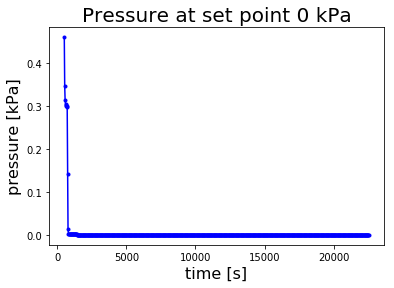

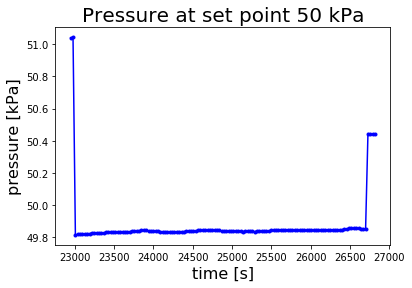

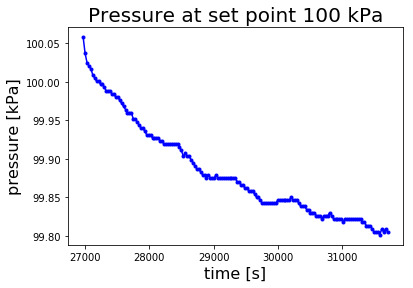

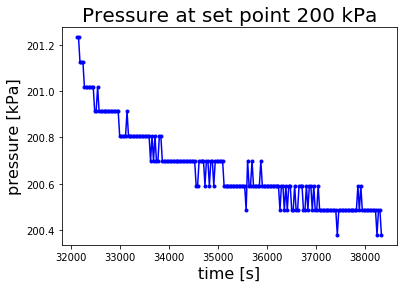

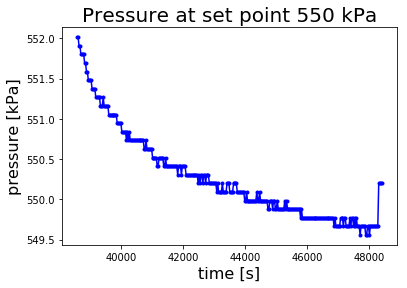

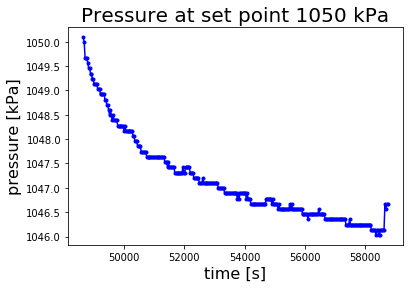

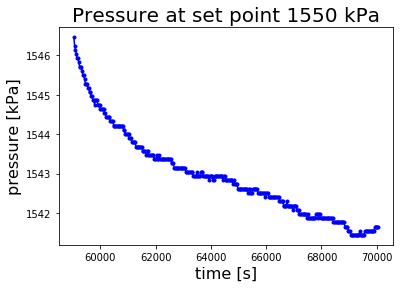

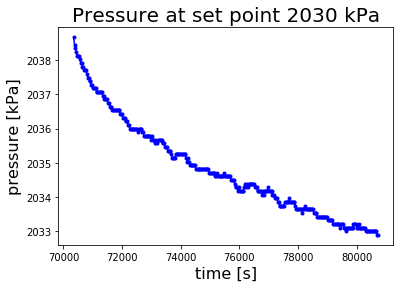

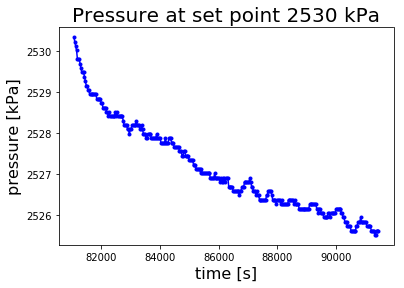

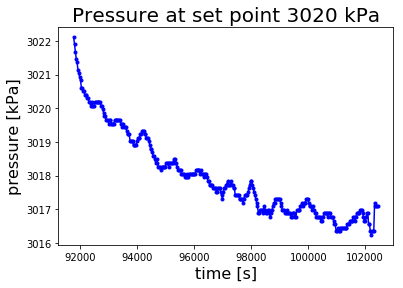

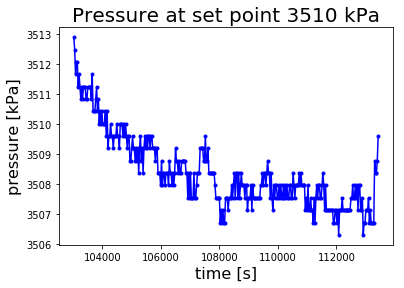

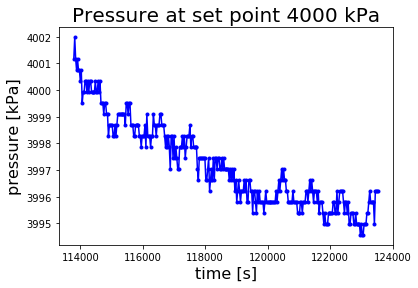

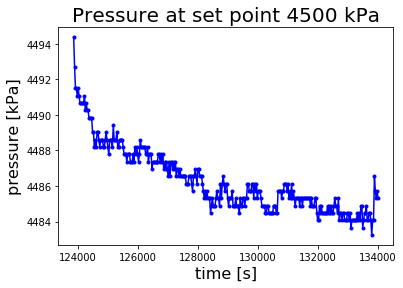

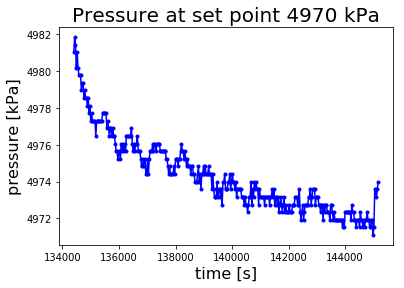

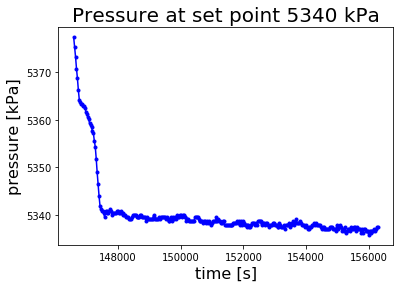

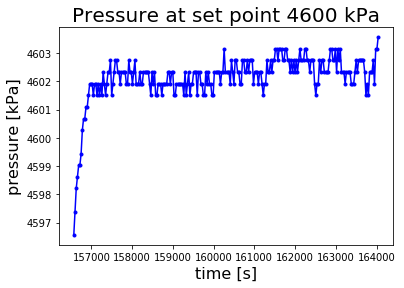

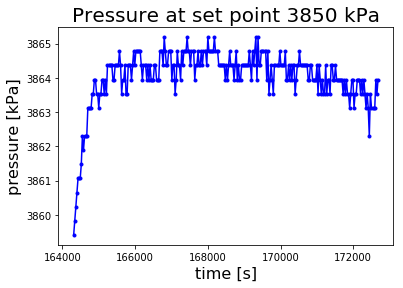

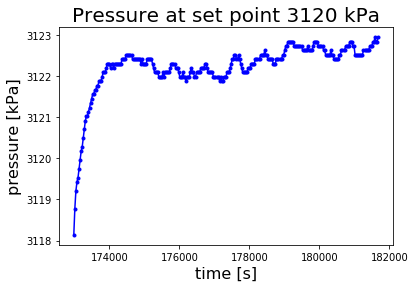

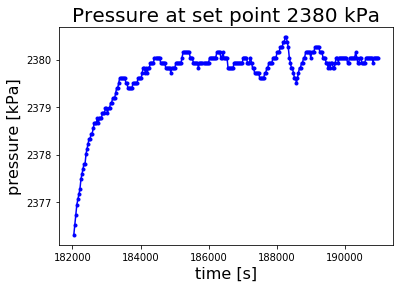

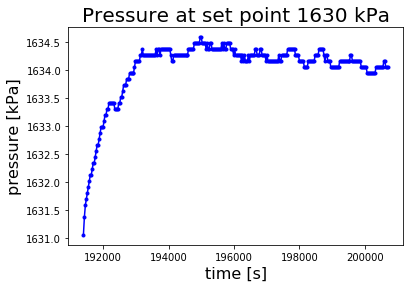

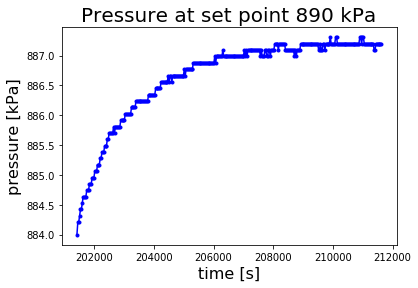

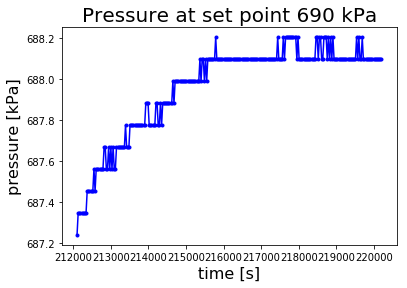

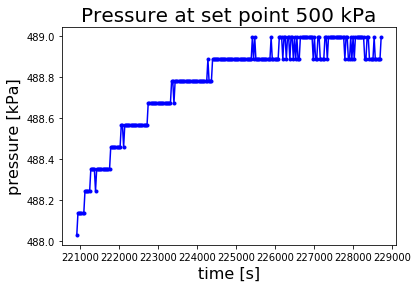

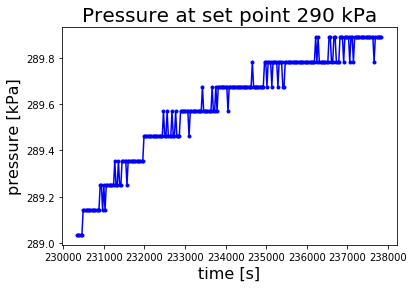

In [3]:
reload(dataproc)
# Identify boundaries of pressure intervals and store gravimetry and ADSA data together after synchronization
# initalize marker for pressure bounds
i_p1 = 0
focus_on_step = False
select_index = 10
plot_p = True
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    if p_set == np.max(p_set_arr):
        window_reduction = 0.01
        print(p_set)
        print(window_reduction)
    else:
        window_reduction = 0.25
    # get indices of each measurement with pressure within thresholds--I checked and it finds the end within 2 or 3 pts.
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1, window_reduction=window_reduction)
    # take mean and standard deviation of final pressure near equilibrium
    p_eq = p_arr[max(i_p0, i_p1-n_p_eq):i_p1]
    df['p actual [kPa]'].iloc[i] = np.mean(p_eq)
    df['p std [kPa]'].iloc[i] = np.std(p_eq)

    if focus_on_step:
        i_p -= 20
        
        if i != select_index:
            continue
    if plot_p:
        # PLOT PRESSURE TO DEBUG IDENTIFICATION OF PRESSURE STEPS
        plot.plot_line(t_grav[i_p0:i_p1], p_arr[i_p0:i_p1], xlabel='time [s]', ylabel='pressure [kPa]',
                 title='Pressure at set point {0} kPa'.format(p_set))
        if focus_on_step:
            ax.set_xlim([220000, 250000])
            ax.set_ylim([4800, 4950])

    # store results in data frame
    df = dataproc.store_grav_adsa(df, i, i_p0, i_p1, t_grav, t_adsa, br_arr, bp_arr, v_drop, n_adsa)

df.head()

Besides at 5300 kPa, where there is always trouble because the CO2 tank cannot provide a higher pressure, in general the pressure remained within 10 kPa of the average value (which was not necessarily the set value).

## Analysis

Next we perform the analysis of the gravimetry and ADSA data to compute the solubility, diffusivity, interfacial tension, and specific volume. We begin with the solubility.

#### Estimation of Polymer Mass and Volume under Vacuum

Before estimating the solubility, I must comptue the mass and volume of the polymer under vacuum.

In [4]:
# balance readings at equilibrium 
br_eq = df['mp1 [g]'].to_numpy(dtype=float) - df['zero [g]'].to_numpy(dtype=float)
# (extract value at 0 pressure) [g]
br_eq_0 = br_eq[0]
# balance reading for the mass of dissolved gas (must be corrected by buoyancy) [g]
br_gas = br_eq - br_eq_0
df['dissolved gas balance reading [g]'] = br_gas

# volume of sample under atmospheric pressure
v_samp_atm = w_samp_atm / rho_samp_atm
# APPROXIMATE weight of gas at atmosphere with linear interpolation--index 2 corresponds to ~100 kPa [g]
w_gas_atm = br_gas[2] + dataproc.rho_co2(P_ATM, T)*(v_samp_atm + v_ref_he)
# APPROXIMATE weight of polymer by subtracting approximated weight of gas from weight of sample at atmosphere
w_poly_ad_hoc = w_samp_atm - w_gas_atm
print('Dry polymer mass from ad hoc extrap = %3f g vs. mass of polymer at atmospheric pressure = %3f g.' % \
      (w_poly_ad_hoc, w_samp_atm))

# compare result to that obtained by using tare measurement of crucible and hook
w_poly = br_eq_0 - TARE
print("Dry polymer mass estimated using tare measurement = " + str(w_poly) + ' g.')
# Volume of sample under vacuum ("dry" polyol) by extrapolating from the volume at 0 pressure
v_drop_0 = v_drop[0] # drop volume under vacuum [uL]
v_poly = v_drop_0 / v_drop_atm * v_samp_atm
print('Volume of dry polymer in crucible is approximately ~ %3f mL (using atmospheric density).' % v_poly)

############################################################################################################
# because the mass estimated using the tare measurement is greater than the atmospheric mass weighed with the
# analytical balance, we will use the ad hoc expression in this case
w_poly = w_poly_ad_hoc

Dry polymer mass from ad hoc extrap = 0.728444 g vs. mass of polymer at atmospheric pressure = 0.729300 g.
Dry polymer mass estimated using tare measurement = 0.7314104249660076 g.
Volume of dry polymer in crucible is approximately ~ 0.744699 mL (using atmospheric density).


### Drop Volume and Sample Volume

Below we plot the measurements of the drop volume and use them to estimate the sample volume (we assume the drop volume increases by the same amount as the sample volume).

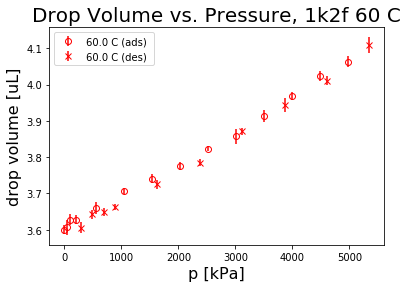

In [5]:
reload(plot)
# Drop volume [uL]
v_drop_eq = df['drop volume [uL]'].to_numpy(dtype=float)
# Use fractional change in drop volume from atmospheric pressure to estimate sample volume
v_samp = v_drop_eq / v_drop_atm * v_samp_atm
df['sample volume [mL]'] = v_samp

# extract data to plot
p_plot = df['p actual [kPa]'].to_numpy(dtype=float)
s_drop_vol = df['drop volume std [uL]'].to_numpy(dtype=float)
# plot equilibrium drop volume vs. p (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_eq, s_drop_vol, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume vs. Pressure, %s %d C' % (polyol, T))

if save_plots:
    plt.savefig(save_folder + 'drop_vol_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

### Error Propagation

To perform error propagation, we define the following uncertainties, which will be used by subroutines later.

In [6]:
reload(errprop)

# set parameters for error propagation
n = len(p_set_arr)
w_poly_arr = w_poly*np.ones([n])
s_v_drop = df['drop volume std [uL]'].to_numpy(dtype=float)
s_frac_rho_co2 = df['p std [kPa]'].to_numpy(dtype=float)/ \
                    df['p actual [kPa]'].to_numpy(dtype=float)  # fractional uncertainty in density is roughly that of p @ eq
w_samp_ref = w_samp_atm*np.ones([n]) # analytical balance measurement of polyol [g]
s_w_samp_ref = 0.00001*np.ones([n]) # error in analytical balance measurement [g]
rho_samp_ref = rho_samp_atm*np.ones([n]) # [g/mL]
s_rho_samp_ref = 0.01*np.ones([n]) # based on density to 2 decimal places from Dow TDS and small temperature diff (25-->30.5 C) [g/mL]
v_samp_ref = v_samp_atm*np.ones([n]) # [mL]
v_drop_ref = v_drop_eq[-2]*np.ones([n]) # approximation of volume of drop at atmospheric pressure w/ p = 130 kPa [uL]
s_v_drop_ref = s_v_drop[-2]*np.ones([n])
v_ref = v_ref_he*np.ones([n]) # [mL]
s_v_ref = 0.01*np.ones([n]) # estimated error in tare volume using He measurement at 35 C [mL]
s_mp1 = df['mp1 std [g]'].to_numpy(dtype=float)
s_zero = df['zero std [g]'].to_numpy(dtype=float)
s_w_gas_ref = 0.00001*np.ones([n]) # ??? [g]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


### Solubility

We perform the following calculations based on  to estimate the solubility of CO2 in the polyol sample.

\begin{align*}
    BR_{eq}(p) &= BR_{mp1}(p) - BR_{zero}(p) \\
\end{align*}

where $BR_{eq}(p)$ is the equilibrium balance reading for the mass of the sample, dissolved gas, crucible, and hook at a pressure $p$; $BR_{mp1}$ is the balance reading at measuring point 1 (tare plus sample, dissolved gas, crucible, and hook); and $BR_{zero}$ is the tare value of the balance.

Then the balance reading for the mass of the gas is computed by subtracting the balance reading under vacuum (at which point we assume no gas in the sample),

\begin{align*}
    BR_{gas}(p) &= BR_{eq}(p) - BR_{eq}(p=0) \\
\end{align*}

where $BR_{gas}$ is the balance reading estimate for the mass of the gas, which requires correction by the buoyancy.

The buoyant force correction to mass is the density of the CO2 atmosphere (estimated using equation of state data from NIST) times the volume of the weighed components,

\begin{align*}
    W_{buoy} &= \rho_{CO2}(p)(V_{samp}(p) + V_{ref}) \\
\end{align*}

where $W_{buoy}$ is the buoyant force correction to the weight, $\rho_{CO2}(p)$ is the density of carbon dioxide at pressure $p$ (assuming a temperature of 30.5 C), $V_{samp}(p)$ is the volume of the sample at pressure $p$, which is calculated as $V_{samp}(p) = V_{drop}(p)\frac{V_{samp}(p=p_{atm})}{V_{drop}(p=_{atm})}$, where $V_{drop}(p)$ is the volume of the pendant drop measured by the FTA32 software and $V_{samp}(p=0)$ is determined with the heuristic discussed above in subsection "Ad Hoc Estimation...". $V_{ref}$ is the volume of the crucible and hook, measured in a reference bath of helium at a temperature 35 C by Maria Rosaria Di Caprio to be 2.2675 mL.

Then the true weight of the gas dissolved in the polyol sample is 

\begin{align*}
    W_{gas} &= BR_{gas} + W_{buoy} \\
\end{align*}

and the solubility is calculated as

\begin{align*}
    w_{CO2} &= \frac{W_{gas}}{W_{gas} + W_{poly}} \\
\end{align*}

where $w_{CO2}$ is the weight/weight solubility of CO2 in the polyol sample and $W_{poly}$ is the dry weight of the polyol sample (under vacuum), as estimated above.

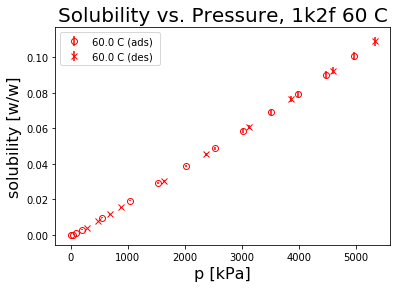

In [7]:
# COMPUTE AND PLOT SOLUBILITY
reload(errprop)
# Drop volume [uL]
v_drop_eq = df['drop volume [uL]'].to_numpy(dtype=float)
# Use fractional change in drop volume from atmospheric pressure to estimate sample volume
v_samp = v_drop_eq / v_drop_atm * v_samp_atm
df['sample volume [mL]'] = v_samp

# calculate "actual gas weight gain" with buoyancy correction; volumes in mL, density in g/mL
w_buoy = dataproc.rho_co2(df['p actual [kPa]'].to_numpy(dtype=float), T)*(v_samp + v_ref_he)
df['buoyancy correction [g]'] = w_buoy
w_gas_act = br_gas + w_buoy
df['actual weight of dissolved gas [g]'] = w_gas_act
# calculate solubility w/w
solubility = w_gas_act / (w_poly + w_gas_act)
df['solubility [w/w]'] = solubility

# propagate the error in the solubility
s_solubility = errprop.error_solubility(solubility, v_samp, w_buoy, w_gas_act, v_drop_eq, 
                                    s_v_drop,  w_poly_arr, s_frac_rho_co2, w_samp_ref, s_w_samp_ref,
                                    rho_samp_ref, s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                    v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
df['solubility error [w/w]'] = s_solubility

# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='r', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Plot with Dow Data

Since Dow has provided data on this polyol in the Sharepoint folder at 25 C and 60 C, we will plot the solubility alongside it. We will also include the data at 30.5 C analyzed earlier.

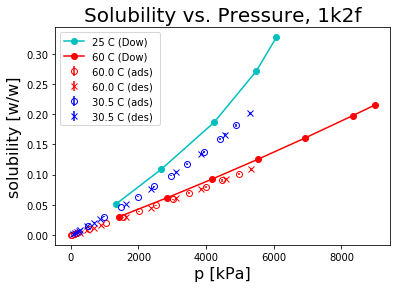

In [8]:
# plot data from Dow (Jacob Crosthwaite) at 25 C and 60 C on VORANOL 2110B
psi2kPa = 6.8948
p_dow_25 = np.array([193.5, 388.7, 614.8, 795.1, 881.5])*psi2kPa
solubility_dow_25 = np.array([0.0509, 0.1088, 0.1865, 0.2711, 0.3273])
p_dow_60 = np.array([206.7, 414.5, 606.1, 802.7, 1002.7, 1207.8, 1304.1])*psi2kPa
solubility_dow_60 = np.array([0.0299, 0.0617, 0.0924, 0.1253, 0.1602, 0.1974, 0.2152])

# extract data from 30.5 C measurement
df_30c = pd.read_csv('..\\g-adsa_results\\1k2f_30c.csv')
p_plot_30c = df_30c['p actual [kPa]'].to_numpy(dtype=float)
solubility_30c = df_30c['solubility [w/w]'].to_numpy(dtype=float)
s_solubility_30c = df_30c['solubility error [w/w]'].to_numpy(dtype=float)
# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='r', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s' % (polyol))
ax = plot.plot_errorbars_ads_des(p_plot_30c, solubility_30c, s_solubility_30c, p_plot_30c, 30.5, ax=ax, color='b')
ax = plot.plot_line(p_dow_25, solubility_dow_25, ax=ax, marker='o', color='c', label='25 C (Dow)')
ax = plot.plot_line(p_dow_60, solubility_dow_60, ax=ax, marker='o', color='r', label='60 C (Dow)')
plt.legend()

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_30c_%dc_dow_data.pdf' % (polyol, T), bbox_inches='tight')

#### Compare Solubility for Different Molecular Weights

We now have data for solubility at similar temperatures for similar polyols at different molecular weights (1000 g/mol for 1k2f and 2700 g/mol for 3k2f), so we will plot them together for comparison.

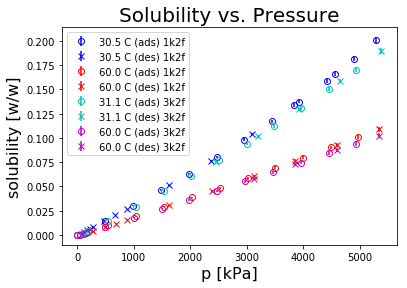

In [9]:
reload(plot)
# Load data from 3k2f 31.1 C data
df_3k2f_31c = pd.read_csv(save_folder + '3k2f_31c.csv')
p_3k2f_31c = df_3k2f_31c['p actual [kPa]'].to_numpy(dtype=float)
solubility_3k2f_31c = df_3k2f_31c['solubility [w/w]'].to_numpy(dtype=float)
s_solubility_3k2f_31c = df_3k2f_31c['solubility error [w/w]'].to_numpy(dtype=float)
# Load data from 3k2f 60 C data
df_3k2f_60c = pd.read_csv(save_folder + '3k2f_60c.csv')
p_3k2f_60c = df_3k2f_60c['p actual [kPa]'].to_numpy(dtype=float)
solubility_3k2f_60c = df_3k2f_60c['solubility [w/w]'].to_numpy(dtype=float)
s_solubility_3k2f_60c = df_3k2f_60c['solubility error [w/w]'].to_numpy(dtype=float)

# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot_30c, solubility_30c, s_solubility_30c, p_set_arr, 30.5, color='b', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure', label_tag='1k2f')
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, ax=ax, color='r', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure', label_tag='1k2f')
ax = plot.plot_errorbars_ads_des(p_3k2f_31c, solubility_3k2f_31c, s_solubility_3k2f_31c, p_3k2f_31c, 31.1, ax=ax, 
                                 color='c', label_tag='3k2f')
ax = plot.plot_errorbars_ads_des(p_3k2f_60c, solubility_3k2f_60c, s_solubility_3k2f_60c, p_3k2f_60c, 60, ax=ax, 
                                 color='m', label_tag='3k2f')

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc_%dc_%s_%dc_%dc.pdf' % (polyol, 30, 60, '3k2f', 31, 60), bbox_inches='tight')

### Specific Volume

The specific volume is calculated as

\begin{align*}
    v(p) &= \frac{V_{samp}(p)}{W_{gas} + W_{poly}} \\
\end{align*}

for which we have already calculated the necessary values.

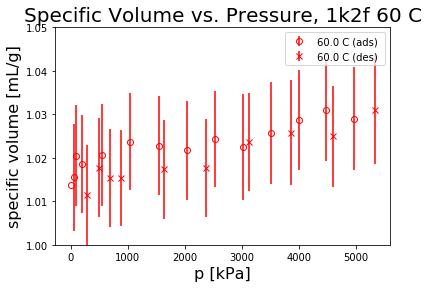

In [10]:
reload(errprop)

# calculate specific volume
spec_vol = v_samp / (w_gas_act + w_poly)
df['specific volume [mL/g]'] = spec_vol

# propagate error to estimate uncertainty
s_spec_vol = errprop.error_spec_vol(spec_vol, v_samp, w_buoy, w_gas_act, v_drop_eq, 
                                    s_v_drop,  w_poly_arr, s_frac_rho_co2, w_samp_ref, s_w_samp_ref,
                                    rho_samp_ref, s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                    v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
df['specific volume error [mL/g]'] = s_spec_vol

# save results
df.to_csv(save_folder + save_data_name)

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, spec_vol, s_spec_vol, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='specific volume [mL/g]', title='Specific Volume vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([1, 1.05])

# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Plot with low-temperature data for specific volume

We will also plot the low-temperature data alongside the high-temperature data for specific volume below.

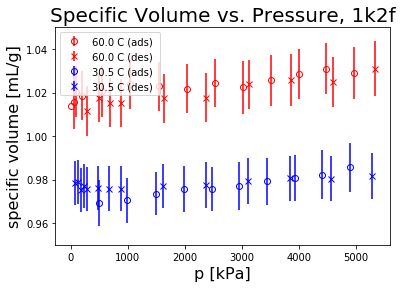

In [11]:
# Load low-temperature (31 C) data
spec_vol_30c = df_30c['specific volume [mL/g]'].to_numpy(dtype=float)
s_spec_vol_30c = df_30c['specific volume error [mL/g]'].to_numpy(dtype=float)

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, spec_vol, s_spec_vol, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='specific volume [mL/g]', title='Specific Volume vs. Pressure, %s' % (polyol))
ax = plot.plot_errorbars_ads_des(p_plot_30c, spec_vol_30c, s_spec_vol_30c, p_plot_30c, 30.5, ax=ax, color='b')
ax.set_ylim([0.95, 1.05])
plt.legend(loc=2)
# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_%s_30c_%dc.pdf' % (polyol, T), bbox_inches='tight')

Having computed the specific volume, we store it as the sample density along with the density of the carbon dioxide atmosphere for use in FTA32 software to compute the interfacial tension properly.

In [12]:
reload(dataproc)
# Store densities of CO2 atmosphere and sample in csv file
for i in range(len(adsa_t0_list)):
    adsa_file = adsa_volume_file_list[i]
    t0 = adsa_t0_list[i]
    # build dataframe
    df_densities = dataproc.store_densities(df, adsa_folder, adsa_file, t0, t_grav, p_arr, T)
    # save dataframe to csv for use in FTA32 analysis
    df_densities.to_csv(adsa_folder + adsa_file[:adsa_file.find('adsa')] + 'adsa_densities.csv', index=False)

#### Plotting mass of absorbed gas over time

For visual analysis, we plot the absorption of gas over time alongside the pressure

Pressure = 0 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 50 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 100 kPa.
Pressure = 200 kPa.
Pressure = 550 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 1050 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 1550 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 2030 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 2530 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3020 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3510 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 4000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 4500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 4970 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 5340 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 4600 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3850 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3120 kPa.


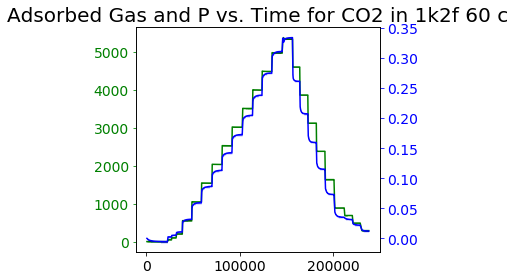

In [13]:
from scipy.signal import medfilt
reload(dataproc)

# Set plot parameters
lw = 2
ax_fs = 16
t_fs = 20
tk_fs = 14
colors = ['g', 'b']
line_styles = ['--',  '-']
ms = 0.005
x_lim = [80000, 400000]
y_lim = [7.88, 7.9]

# initalize marker for pressure bounds
last_bound = 0
# initialize array to store p, t, and gas weight for plotting
w_gas_2_plot = np.array([])
p_2_plot = np.array([])
t_2_plot = np.array([])
# initialize mass of gas from end of previous pressure step as initial mass M_0 [g]
M_0_prev = np.zeros([len(p_set_arr)])
# initialize array of mass of gas at equilibrium using last mass of current pressure step [g]
M_infty_final = np.zeros([len(p_set_arr)])
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    # get indices of each measurement with pressure within thresholds 
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
    # extract data for current pressure
    t_select = t_grav[i_p0:i_p1]
    br_select = br_arr[i_p0:i_p1]
    bp_select = bp_arr[i_p0:i_p1]
    p_select = p_arr[i_p0:i_p1]
    
    # extract mp1 measurements and corresponding times for the current pressure set point
    is_mp1 = (bp_select == 2)
    mp1 = medfilt(br_select[is_mp1], kernel_size=5) # medfilt removes spikes from unstable measurements
    t_mp1 = t_select[is_mp1]
    p_mp1 = p_select[is_mp1]
    
    w_gas_act, t_mp1, df, last_bound = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, t_grav, 
                                                                      p_thresh_frac, last_bound, v_ref_he)
    w_gas_act_eq = np.mean(w_gas_act[-n_p_eq:])
    # save gas mass from current run for next M_0
    if i < len(p_set_arr)-1:
        M_0_prev[i+1] = w_gas_act_eq
    # save gas mass from current run for current M_infty
    M_infty_final[i] = w_gas_act_eq
    
    # skip if data has nans
    if np.isnan(w_gas_act.any()):
        continue
        
    # append data for plotting
    w_gas_2_plot = np.append(w_gas_2_plot, w_gas_act)
    p_2_plot = np.append(p_2_plot, p_mp1)
    t_2_plot = np.append(t_2_plot, t_mp1)

# save initial mass estimated using previous gas mass [g]
df['M_0 (prev) [g]'] = M_0_prev
# save final gas mass [g]
df['M_infty (final) [g]'] = M_infty_final

# Plot adsorbed gas and pressure over time
ax = plot.plot_two_axes(t_2_plot, p_2_plot, w_gas_2_plot, markers=['o', '^'], labels=['p', r'$w_{gas}$'], 
                        title='Adsorbed Gas and P vs. Time for CO2 in %s %d c' % (polyol, T), colors=colors, ms=ms)

# save plot ?
if save_plots:
    plt.savefig(save_folder + 'gas_weight_%s_%dc.pdf' % (polyol, T), bbox_inches="tight")

### Interfacial Tension

At this point, I use the program auto_density_input_fta32.py to automatically click the right buttons in the FTA32 software to compute the interfacial tension. Once this document has been filled out, the interfacial tension can be plotted and saved below.

Pressure = 0 kPa.
Rejected 1 outliers.
Interfacial tension = 25.157000 mN/m.
Pressure = 50 kPa.
Rejected 1 outliers.
Interfacial tension = 24.984000 mN/m.
Pressure = 100 kPa.


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Interfacial tension = 24.830000 mN/m.
Pressure = 200 kPa.
Interfacial tension = 24.557000 mN/m.
Pressure = 550 kPa.
Rejected 1 outliers.
Interfacial tension = 23.897000 mN/m.
Pressure = 1050 kPa.
Rejected 1 outliers.
Interfacial tension = 22.874000 mN/m.
Pressure = 1550 kPa.
Rejected 1 outliers.
Interfacial tension = 21.952000 mN/m.
Pressure = 2030 kPa.
Rejected 1 outliers.
Interfacial tension = 21.129000 mN/m.
Pressure = 2530 kPa.
Rejected 1 outliers.
Interfacial tension = 20.046000 mN/m.
Pressure = 3020 kPa.
Rejected 1 outliers.
Interfacial tension = 19.193000 mN/m.
Pressure = 3510 kPa.
Rejected 1 outliers.
Interfacial tension = 18.201000 mN/m.
Pressure = 4000 kPa.
Rejected 1 outliers.
Interfacial tension = 17.355000 mN/m.
Pressure = 4500 kPa.
Rejected 1 outliers.
Interfacial tension = 16.426000 mN/m.
Pressure = 4970 kPa.
Rejected 1 outliers.
Interfacial tension = 15.461000 mN/m.
Pressure = 5340 kPa.
Rejected 1 outliers.
Interfacial tension = nan mN/m.
Pressure = 4600 kPa.
Rejected 1

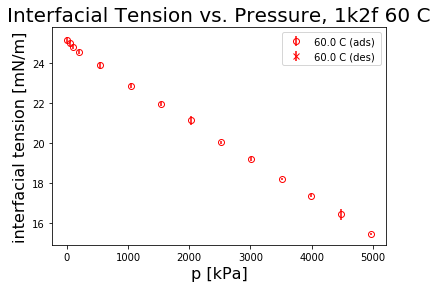

In [14]:
reload(dataproc)
# load interfacial tension data
if_tension = np.array([])
for i in range(len(adsa_if_tension_file_list)):
    adsa_if_tension_file = adsa_if_tension_file_list[i]
    df_if_tension = pd.read_csv(adsa_folder + adsa_if_tension_file, header=0)
    if_tension = np.concatenate((if_tension, df_if_tension['Interfacial Tension [mN/m]'].to_numpy(dtype=float)))

# has interfacial tension data been provided?
if len(if_tension) > 0:
    # store interfacial tension for each pressure
    i_p1 = 0
    for i in range(len(p_set_arr)):
        p_set = p_set_arr[i]
        print('Pressure = %d kPa.' % p_set)
        # get indices of each measurement with pressure within thresholds
        i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1)
        df = dataproc.store_if_tension(if_tension, df, i, i_p0, i_p1, t_grav, t_adsa, n_adsa)

    # save results
    df.to_csv(save_folder + save_data_name)

    # extract data to plot
    if_tension_plot = df['if tension [mN/m]'].to_numpy(dtype=float)
    s_if_tension = df['if tension std [mN/m]'].to_numpy(dtype=float)
    # plot interfacial tension with errrorbars (blue color for low temperature)
    ax = plot.plot_errorbars_ads_des(p_plot, if_tension_plot, s_if_tension, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                    ylabel='interfacial tension [mN/m]', 
                                     title='Interfacial Tension vs. Pressure, %s %d C' % (polyol, T))

    # save figure
    if save_plots:
        plt.savefig(save_folder + 'if_tension_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Plot Interfacial Tension Data for Different Temperatures

Because we have data for interfacial tension at 30.5 C for 1k2f polyol as well, we will plot the data from the two temperatures together.

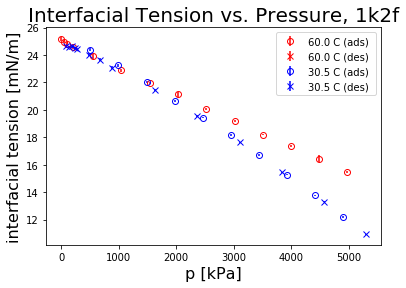

In [16]:
reload(plot)
# has interfacial tension data been provided?
if len(if_tension) > 0:
    
    # extract data to plot
    if_tension_plot = df['if tension [mN/m]'].to_numpy(dtype=float)
    s_if_tension = df['if tension std [mN/m]'].to_numpy(dtype=float)
    if_tension_30c = df_30c['if tension [mN/m]'].to_numpy(dtype=float)
    s_if_tension_30c = df_30c['if tension std [mN/m]'].to_numpy(dtype=float)
    # plot interfacial tension with errorbars (blue color for low temperature)
    ax = plot.plot_errorbars_ads_des(p_plot, if_tension_plot, s_if_tension, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                    ylabel='interfacial tension [mN/m]', 
                                     title='Interfacial Tension vs. Pressure, %s' % (polyol))
    ax = plot.plot_errorbars_ads_des(p_plot_30c, if_tension_30c, s_if_tension_30c, p_plot_30c, 30.5, ax=ax, color='b')

    # save figure
    if save_plots:
        plt.savefig(save_folder + 'if_tension_%s_30c_%dc.pdf' % (polyol, T), bbox_inches='tight')

### Diffusivity

Because the diffusivity changes with the concentration of CO2 in the polyol, and because the concentration of CO2 in the polyol changes substantially during the course of sorption at a single pressure, we cannot justify the assumption that the diffusivity $D$ is constant throughout the sample or throughout the course of sorption. Instead, we must use models that account for a varying diffusivity, as derived by Crank in *The Mathematics of Diffusion* (1956).

#### Model 1: Use Initial Gradient (eqn. 6 in Pastore et al. 2011; eqn. 7 in Vrentas et al. 1977)

For a constant diffusion coefficient $D$ of a gas diffusing into a sheet of thickness $l$ open to atmosphere on both sides, Crank derives in sect 4.3.2 p. 48 that

\begin{align}
\frac{M_t}{M_{\infty}} &= \frac{4}{\pi^{1/2}}\left(\frac{Dt}{l^2}\right)^{1/2} \\
\end{align}

At the start of diffusion, the diffusion coefficient is constant as diffusion almost exclusively occurs within a thin skin layer along the interface between sample and gas. Somehow (***I don't understand this***), this means that the average diffusion coefficient $\bar{D}$ can be approximated by taking the derivative of the above equation with respect to the square-root of time over the sample thickness squared at the beginning of the experiment ($t = t_0$). Thus,

\begin{align*}
\bar{D} &= \frac{\pi}{16}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t/l^2}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

In this experiment, however, the sample is only open to the atmosphere on one side; on the other, there is no flux, so the boundary condition is $\frac{\partial c}{\partial z} = 0$ (where $c$ is the concentration of the gas and $z$ is the direction of diffusion perpendicular to the surface of the sample), which is mathematically identical to the symmetry condition in the system considered by Crank at the center of the sample. Thus, the present system can be mapped onto that of Crank by simply replacing $l$ (the thickness of the sample exposed to gas on two sides) with $2h_{samp}$ (where $h_{samp}$ is the thickness of the sample in the sorption experiment exposed to gas on one side). Thus,

\begin{align*}
\bar{D} &= \frac{\pi h_{samp}^2}{4}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

According to the first equation in this cell (10.165 in Crank's textbook), the mass of the sample will initially increase as $t^{1/2}$, so we fit the sample weight at the beginning of sorption to the equation 

\begin{align*}
W_{gas}^{act} &= a \sqrt{t-t_0^{fit}} + b\\
\end{align*}

with fitting parameters $a$, $t_0^{fit}$, and $b$.

$M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ (the dry mass of the polymer under vacuum) is constant, the time derivatives of the gas mass and the total mass are the same. Therefore, at $t = t_0^{fit}$,

\begin{align*}
\left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}W_{gas}^{act}\right|_{t=t_0^{fit}} &= \left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}\left(a \sqrt{t-t_0^{fit}} + b\right)\right|_{t=t_0^{fit}}\\
\left.\frac{\mathrm{d}M_t}{\mathrm{d}\sqrt{t}}\right|_{t=t_0^{fit}} &= a \\
\end{align*}

We can then use the above equation relating the time derivative of the sample mass at the initial time of sorption/desorption $t_0^{fit}$ to the average diffusion constant,

\begin{align*}
\sqrt{M_{\infty}^2\bar{D} \frac{4}{\pi h_{samp}^2}} &= a\\
\bar{D} &= \left(\frac{\pi h_{samp}^2}{4}\right)\left(\frac{a}{M_{\infty}}\right)^2 \\
\end{align*}

As a result, the only remaining parameter to estimate is $M_{\infty}$, the equilibrium mass of the sample. Scaling analysis (***ADD LATER***) shows that at late times the sample mass approaches the equilibrium mass exponentially. Thus, to estimate the equilibrium mass, we fit an exponential curve of the following form to the late-time data points,

\begin{align*}
W_{gas}^{act} &= A e^{Bt} + M_{\infty}\\
\end{align*}

where $A$, $B$, and $M_{\infty}$ are fitting parameters. We then use the fitted value for $M_{\infty}$ and estimate the average diffusion coefficient $\bar{D}$ with the equation above.

In [ ]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:50, 2:100, 3:200, 4:550, 5:1050, 6:1550, 7:2030, 8:2530, 9:3020, 10:3510, 11:4000, 12:4500,
#                        13:4970, 14:5340, 15:4600, 16:3850, 17:3120, 18:2380, 19:1630, 20:890, 21:690, 22:500, 23:290])
reload(dataproc)
# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
n_pts_sqrt_arr = 50*np.ones([len(p_set_arr)]).astype(int)
n_pts_sqrt_arr[1] = 20
n_pts_sqrt_arr[15] = 40
n_pts_sqrt_arr[16:18] = 35
n_pts_sqrt_arr[19] = 55
n_pts_sqrt_arr[20] = 55
n_pts_sqrt_arr[23] = 70
# number of data points to use for fitting to exponential (end of curve)
n_pts_exp = 50
# shift in indices to cut off beginning data points that don't match t^1/2 fit
i_shift = np.ones(len(p_set_arr)).astype(int)
i_shift[1] = 11
i_shift[3] = 4
i_shift[13] = 3
i_shift[14] = 60
i_shift[15] = 15
i_shift[16:] = 3

# initialize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_sqrt_arr = np.zeros([len(p_set_arr)])
# initialize array to store initial mass M_0 extrapolated with t^1/2 fit
M_0_extrap = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):   
    if i == 0:
        continue
        
    p_set = p_set_arr[i]
    n_pts_sqrt = n_pts_sqrt_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    
    # the initial time of sorption is defined as the point where the pressure began changing after the previous sorption test
    i_t0 = last_bound
    t0 = t_grav[i_t0]
    # get indices of each measurement with pressure within thresholds 
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
    t_init = t_grav[i_p0]
    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, t_grav, 
                     p_thresh_frac, last_bound, v_ref_he)
    # additional cutting off of data for t^1/2 fit
    t_mp1 = t_mp1[i_shift[i]:]
    w_gas_act = w_gas_act[i_shift[i]:]
    
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
      
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    n = min(n_pts_sqrt, len(t_mp1)-1)
    popt, pcov = curve_fit(dataproc.square_root_3param, t_mp1[:n], w_gas_act[:n], maxfev=maxfev)
    a = popt[0]
    w0 = popt[1]
    t0_fit = popt[2]
    
    # generate data points for t^(1/2) fit
    t_fit = np.linspace(t_mp1[0], t_mp1[n-1], 100)
    w_fit = dataproc.square_root_3param(t_fit, a, w0, t0_fit)
    # plot the result to examine the fit
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # plot data translated such that first point is 0,0 and data increases (so t^1/2 looks like a straight line on log-log)
    is_adsorbing = i <= np.argmax(p_set_arr)
    sign = 2*(is_adsorbing-0.5)
    ax.loglog(t_mp1 - t0_fit, sign*(w_gas_act - w0), '^', label='data')
    ax.loglog(t_fit - t0_fit, sign*(w_fit - w0), '-', label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=w0, t0=t0_fit))
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$\Delta w_{CO2}$ [g]')
    if is_adsorbing:
        stage = 'Adsorption'
    else:
        stage = 'Desorption'
    ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C' % (polyol, p_set, T))
    plt.legend(loc='best')

    # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
    D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df)
    print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
    # store result
    D_sqrt_arr[i] = D_sqrt
    
    # Also save the "initial" mass extrapolated to the beginning of the change in pressure
    M_0_extrap[i] = dataproc.square_root_3param(max(t0, t0_fit), a, w0, t0_fit)
    print('t_init = ' + str(t_init))
    print('t0_fit = ' + str(t0_fit))
    print('t0 = ' + str(t0))
    print('w0 = ' + str(w0))
    

Pressure = 50 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 2.00e-07 cm^2/s.
t_init = 22950
t0_fit = 22890.893238448403
t0 = 0
w0 = 0.002433124447705657
Pressure = 100 kPa.
D_sqrt = 2.68e-07 cm^2/s.
t_init = 26970
t0_fit = 26964.304322959266
t0 = 26850
w0 = 0.004740950678380236
Pressure = 200 kPa.
D_sqrt = 2.49e-07 cm^2/s.
t_init = 32130
t0_fit = 32182.713003171637
t0 = 31740
w0 = 0.009575751077384167
Pressure = 550 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 4.08e-07 cm^2/s.
t_init = 38580
t0_fit = 38559.26928836179
t0 = 38370
w0 = 0.026480200648613304
Pressure = 1050 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 2.65e-07 cm^2/s.

C:\Users\Andy.DESKTOP-CFRG05F\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\g-adsa\dataproc.py:399: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b



t_init = 48660
t0_fit = 48623.50916472963
t0 = 48420
w0 = 0.05171751267471862
Pressure = 1550 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.38e-07 cm^2/s.
t_init = 59040
t0_fit = 59000.947581613276
t0 = 58770
w0 = 0.07824740947011731
Pressure = 2030 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 8.42e-08 cm^2/s.
t_init = 70350
t0_fit = 70305.80774780117
t0 = 70080
w0 = 0.10487980346868847
Pressure = 2530 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 5.99e-08 cm^2/s.
t_init = 81060
t0_fit = 81008.96811127191
t0 = 80760
w0 = 0.1340260422458556
Pressure = 3020 kPa.
Rejected 1 outliers.
Rejected 1 outliers.


Having computed the mean diffusivities, we will save them.

In [ ]:
# record diffusivity calculated using the t^(1/2) (squareroot) fit in the data frame [cm^2/s]
df['diffusivity (sqrt) [cm^2/s]'] = D_sqrt_arr
# record "initial" mass extrapolated to be at beginning of pressure quench
df['M_0 (extrap) [g]'] = M_0_extrap

# save results
df.to_csv(save_folder + save_data_name)

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr, np.zeros([len(D_sqrt_arr)]), p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', 
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Compare Diffusivity at Different Temperatures

Compare diffusivity in 1k2f at 30.5 C and 60 C computed using the square-root fit.

In [ ]:
# load data frame of 30 C 1k2f data
df_30 = pd.read_csv(save_folder + '1k2f_30c.csv')
# load diffusivity calculated using the t^(1/2) (squareroot) fit in the data frame [cm^2/s]
D_sqrt_arr_30 = df_30['diffusivity (sqrt) [cm^2/s]']
# load corresponding pressures
p_plot_30 = df_30['p actual [kPa]']

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr, np.zeros([len(D_sqrt_arr)]), p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', 
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s' % (polyol))
ax = plot.plot_errorbars_ads_des(p_plot_30, D_sqrt_arr_30, np.zeros([len(D_sqrt_arr_30)]), p_plot_30, 30.5, ax=ax, color='b')
ax.set_yscale('log')

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_%s_30C_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Model 1b: Fix t0 as the beginning of the change in pressure

Physically, the diffusion kinetics should follow a $t^{1/2}$ power law after the pressure changes, so the starting time $t_0$ should match the start of the change in pressure (roughly). In this method, we fix that point and fit the coefficient and intercept (two parameters free instead of the three free parameters from the previous section).

In [ ]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:50, 2:100, 3:200, 4:550, 5:1050, 6:1550, 7:2030, 8:2530, 9:3020, 10:3510, 11:4000, 12:4500,
#                        13:4970, 14:5340, 15:4600, 16:3850, 17:3120, 18:2380, 19:1630, 20:890, 21:690, 22:500, 23:290])
reload(dataproc)
# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
n_pts_sqrt_arr = 50*np.ones([len(p_set_arr)]).astype(int)
n_pts_sqrt_arr[1] = 20
n_pts_sqrt_arr[15] = 40
n_pts_sqrt_arr[16:18] = 35
n_pts_sqrt_arr[19] = 55
n_pts_sqrt_arr[20] = 55
n_pts_sqrt_arr[23] = 70
# number of data points to use for fitting to exponential (end of curve)
n_pts_exp = 50
# shift in indices to cut off beginning data points that don't match t^1/2 fit
i_shift = np.ones(len(p_set_arr)).astype(int)
i_shift[1] = 11
i_shift[3] = 4
i_shift[13] = 3
i_shift[14] = 60
i_shift[15] = 15
i_shift[16:] = 3

# initialize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_sqrt_arr = np.zeros([len(p_set_arr)])
# initialize array to store initial mass M_0 extrapolated with t^1/2 fit
M_0_extrap = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    n_pts_sqrt = n_pts_sqrt_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # the initial time of sorption is defined as the point where the pressure began changing after the previous sorption test
    i_t0 = last_bound
    t0 = t_grav[i_t0]
    # get indices of each measurement with pressure within thresholds 
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
    t_init = t_grav[i_p0]
    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, t_grav, 
                     p_thresh_frac, last_bound, v_ref_he)
    # additional cutting off of data for t^1/2 fit
    t_mp1 = t_mp1[i_shift[i]:]
    w_gas_act = w_gas_act[i_shift[i]:]
    
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
      
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    n = min(n_pts_sqrt, len(t_mp1)-1)
    popt, pcov = curve_fit(dataproc.square_root_2param, t_mp1[:n]-t0, w_gas_act[:n], maxfev=maxfev)
    a = popt[0]
    w0 = popt[1]
    
    # generate data points for t^(1/2) fit
    t_fit = np.linspace(t_mp1[0], t_mp1[n-1], 100) - t0
    w_fit = dataproc.square_root_2param(t_fit, a, w0)
    # plot the result to examine the fit
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # plot data translated such that first point is 0,0 and data increases (so t^1/2 looks like a straight line on log-log)
    is_adsorbing = i <= np.argmax(p_set_arr)
    sign = 2*(is_adsorbing-0.5)
    ax.loglog(t_mp1 - t0, sign*(w_gas_act - w0), '^', label='data')
    ax.loglog(t_fit, sign*(w_fit - w0), '-', label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=w0, t0=t0))
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$\Delta w_{CO2}$ [g]')
    if is_adsorbing:
        stage = 'Adsorption'
    else:
        stage = 'Desorption'
    ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C' % (polyol, p_set, T))
    plt.legend(loc='best')

    # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
    D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df)
    print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
    # store result
    D_sqrt_arr[i] = D_sqrt
    
    # Also save the "initial" mass extrapolated to the beginning of the change in pressure
    M_0_extrap[i] = w0
    print('t_init = ' + str(t_init))
    print('t0 = ' + str(t0))
    print('w0 = ' + str(w0))

In [ ]:
# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr, 0.5*np.zeros([len(D_sqrt_arr)]), p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', 
                                 title='Diffusivity by Square-root Fit (2-param) vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_2param_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Model 2: Exponential Fit (based on equation 10.168 in section 10.6.8 of Crank, 1956)

In the later stages of diffusion, Crank demonstrates that the mass of a sample in an atmosphere of diffusing gas obeys the following equation (equation 10.168 in *The Mathematics of Diffusion*, 1956),

\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}t}\left[\log(M_t - M_{\infty})\right] &= - \frac{D \pi^2}{l^2} \\
\end{align*}

At late enough times, the concentration is close enough to the equilibrium value that the affect of the changing concentration in the system on the diffusion coefficient $D$ is negligible. Therefore, in this model, we assume that $D$ is constant and corresponds to the diffusion coefficient at the equilibrium concentration.

As above, to map this system to the present system where the sample is only exposed to gas on one surface and has a no-flux condition on the other, we replace $l$ with $2 h_{samp}$. We can then integrate the above equation to arrive at the following functional form for the mass of the sample,

\begin{align*}
M_t &= M_{\infty} - (M_{\infty} - M_0) \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\frac{M_{\infty} - M_t}{M_{\infty} - M_0} &= \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\end{align*}

where **in this case, as opposed to above for the $t^{1/2}$ fit, $M_0$ is the mass of the sample at the beginning of the exponential behavior (which we define as $t=0$).**

As noted before, $M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ is constant, it can be "absorbed" in the constant $M_{\infty}$ (so the constant term would represent the equilibrium mass of adsorbed gas rather than of the total sample mass). We can then perform a fit of the mass of adsorbed gas to the following functional form,

\begin{align*}
W_{gas}^{act} &= A \exp \left[B t\right] + C \\
\end{align*}

where $A$, $B$, and $C$ are fitting parameters. Then $C$ is the equilibrium mass of adsorbed gas $W_{gas,\infty}^{act}$ and $B$ can be related to the diffusion constant $D$ by the following equation,

\begin{align*}
D &= -\frac{4 h_{samp}^2}{\pi^2} B\\
\end{align*}

***DEMONSTRATE THAT CHANGE IN H_SAMP IS NEGLIGIBLE (HOW SMALL?)***

In [ ]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:50, 2:100, 3:200, 4:550, 5:1050, 6:1550, 7:2030, 8:2530, 9:3020, 10:3510, 11:4000, 12:4500,
#                        13:4970, 14:5340, 15:4600, 16:3850, 17:3120, 18:2380, 19:1630, 20:890, 21:690, 22:500, 23:290])

# set number of points for exponential fit
n_pts_exp_arr = 120*np.ones([len(p_set_arr)]).astype(int)
n_pts_exp_arr[1] =100
n_pts_exp_arr[4] = 200
n_pts_exp_arr[6:22] = 200
n_pts_exp_arr[13:15] = 250

# set shift of end point
i_shift_exp_arr = -np.ones([len(p_set_arr)]).astype(int)
i_shift_exp_arr[2] = -10
i_shift_exp_arr[4] = -10
i_shift_exp_arr[9] = -10
i_shift_exp_arr[10] = -25
i_shift_exp_arr[11] = -10
i_shift_exp_arr[12] = -10
i_shift_exp_arr[13] = -10
i_shift_exp_arr[14] = -10
i_shift_exp_arr[15] = -25
i_shift_exp_arr[16] = -10
i_shift_exp_arr[18] = -10
i_shift_exp_arr[19:23] = -5
i_shift_exp_arr[23] = -10

# initalize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_exp_arr = np.zeros([len(p_set_arr)])
# initialize array of extrapolated mass at t --> infinity
M_infty_arr = np.zeros([len(p_set_arr)])
# initialize array to store fitted exponential time constants [s]
tau_arr = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    n_pts_exp = n_pts_exp_arr[i]
    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, 
                                                                               t_grav, p_thresh_frac, last_bound, v_ref_he)

    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
        
    # fit initial data points to an exponential curve per eqn 10.168 in Crank (1956) "The Mathematics of Diffusion"
    # shift time to start at t = 0
    i_shift_exp = i_shift_exp_arr[i]
    popt, pcov = curve_fit(dataproc.exponential_approach, t_mp1[-n_pts_exp:i_shift_exp]-t_mp1[-n_pts_exp], 
                           w_gas_act[-n_pts_exp:i_shift_exp], maxfev=maxfev, p0=(-0.01, -0.01, 0.1))
    a, b, c = popt
    # generate data points for exponential fit
    t_fit = np.linspace(t_mp1[-n_pts_exp], t_mp1[-1], 100) - t_mp1[-n_pts_exp]
    w_fit = dataproc.exponential_approach(t_fit, a, b, c)
    # plot the result to examine the fit
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.semilogy(t_mp1[:i_shift_exp], np.abs(c - w_gas_act[:i_shift_exp]), '^', label='data')
    ax.semilogy(t_fit + t_mp1[-n_pts_exp], np.abs(c - w_fit), '-', label=r'{a:.1e}exp({b:.1e}t); $M_\infty=${c:.1e}' \
                .format(a=a, b=b, c=c))
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$M_{\infty} - M_{CO2}$ [g]')
    ax.tick_params(axis='y', which='minor', left=True)
    is_adsorbing = i <= np.argmax(p_set_arr)
    if is_adsorbing:
        stage = 'Adsorption'
    else:
        stage = 'Desorption'
    ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C' % (polyol, p_set, T))
    plt.legend(loc='best')

    D_exp = dataproc.compute_D_exp(i, diam_cruc, df, b)
    print('D_exp = %.2e cm^2/s.' % D_exp)
    # store result
    D_exp_arr[i] = D_exp
    
    # Store mass estimated at time --> infinity
    M_infty_arr[i] = c
    # store fitted exponential time constant [s]
    tau_arr[i] = -1/b

Having computed the mean diffusivities, we will save them.

In [ ]:
# record diffusivity calculated using the exponential fit in the data frame [cm^2/s]
df['diffusivity (exp) [cm^2/s]'] = D_exp_arr
# record mass extrapolated at time goes to infinity [g]
df['M_infty (extrap) [g]'] = M_infty_arr
# record fitted exponential time constant [s]
df['diffusion time constant [s]'] = tau_arr

# save results
df.to_csv(save_folder + save_data_name)

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_exp_arr, np.zeros([len(D_exp_arr)]), p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', 
                                 title='Diffusivity by Exponential Fit vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_exp_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Compare Exponential-fit Diffusivities of 1k2f at Different Temperatures

Compare 30.5 C and 60 C

In [ ]:
# load diffusivity calculated using the exponential fit in the data frame [cm^2/s]
D_exp_arr_30 = df_30['diffusivity (exp) [cm^2/s]']

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_exp_arr, np.zeros([len(D_exp_arr)]), p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', 
                                 title='Diffusivity by Exponential Fit vs. Pressure, %s' % (polyol))
ax = plot.plot_errorbars_ads_des(p_plot_30, D_exp_arr_30, np.zeros([len(D_exp_arr_30)]), p_plot_30, 30.5, ax=ax, color='b')
ax.set_yscale('log')

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_exp_%s_30C_%dC.pdf' % (polyol, T), bbox_inches='tight')